# Data Collection

Needed to gather historical data regarding player, teams, etc.

Fortunately, [ESPN Scrum](espnscrum.com) provides a data on players, teams, and matches going back to 1896. 

Using a scrapy spider built by peloyeje (found [here](https://github.com/peloyeje/map536-rugby-data-scraper)), it was possible to collect a meaningful sample of matches and results, along with player stats for each match to work with.

Additionally, the World Rugby rankings were gathered from World Rugby's website using Beautiful Soup.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("rankings.csv")

data

,team_name,abbreviation,num_matches,pts,pos,prev_pts,prev_pos,date
0,England,ENG,11,89.948520,1,89.948520,1,2003-10-13
1,New Zealand,NZL,11,89.797710,2,89.797710,2,2003-10-13
2,Australia,AUS,11,84.762690,3,83.805620,4,2003-10-13
3,Ireland,IRE,11,83.924580,4,83.924580,3,2003-10-13
4,France,FRA,11,82.845314,5,82.845314,5,2003-10-13
...,...,...,...,...,...,...,...,...
577110,Monaco,MON,12,23.171558,101,23.171558,101,2019-11-14
577111,Greece,GRE,17,22.546452,102,22.546452,102,2019-11-14
577112,Indonesia,INA,5,21.891422,103,21.891422,103,2019-11-14
577113,Vanuatu,VAN,16,21.453693,104,21.453693,104,2019-11-14


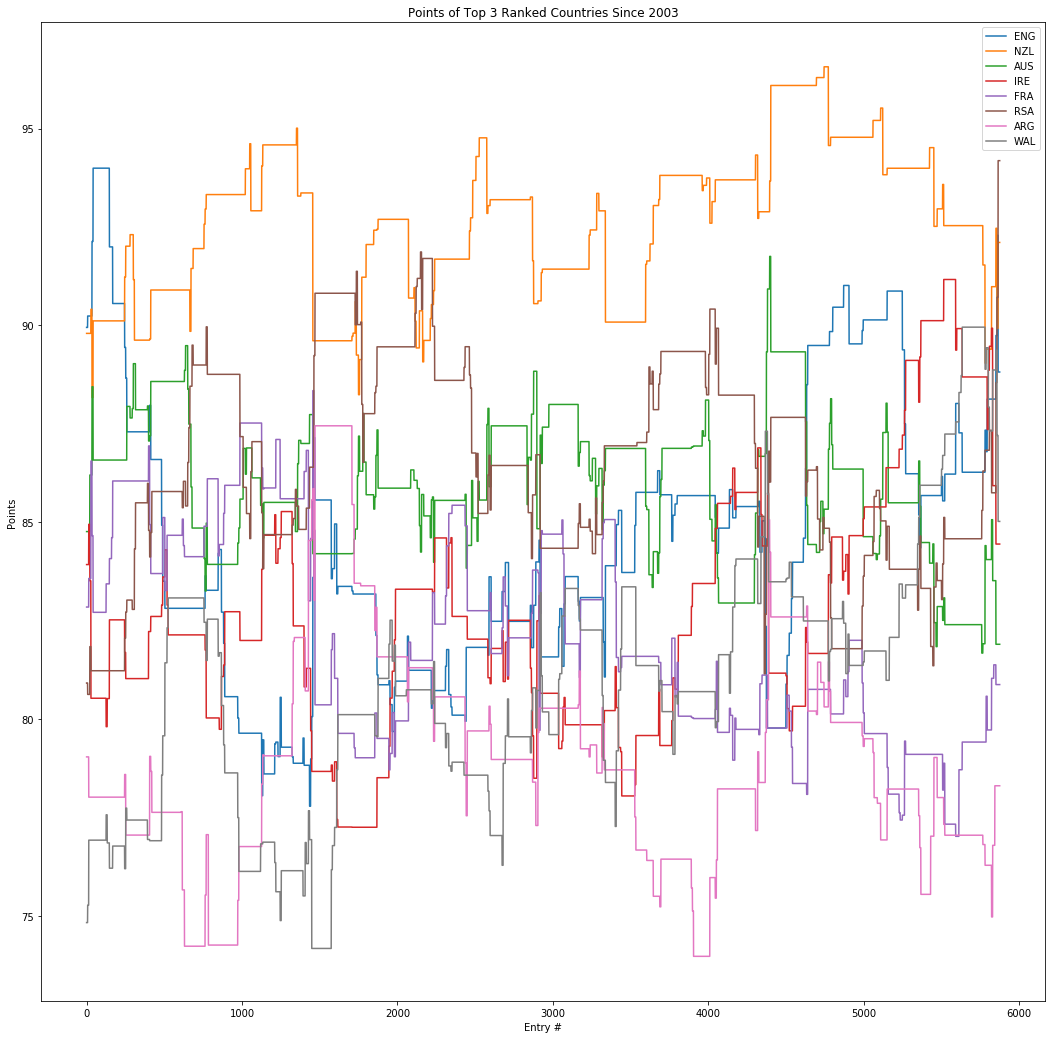

In [4]:
fig = plt.figure(figsize=(18, 18))

for abbr in data.loc[data.pos < 4].abbreviation.unique():
    abbr_pts = data.loc[data.abbreviation == abbr].values[:,[3]]
    plt.plot(abbr_pts, label = abbr)
    
plt.title("Points of Top 3 Ranked Countries Since 2003")
plt.xlabel("Entry #")
plt.ylabel("Points")
plt.legend()
plt.show()

The following table was created directly from 'rankings.csv' by first inserting the file into a postgres server and then using the SQL command:<br />
~~~~sql
    SELECT team_name, pos, extract(year FROM date) AS year, AVG(points)
    FROM rankings
    GROUP BY team_name, pos, year
    HAVING pos < 4
    ORDER BY year;
~~~~

In [5]:
data = pd.read_csv("avg_pts_perteam_perpos_peryr.csv")

data

,team_name,pos,year,avg
0,Australia,2,2003,88.441790
1,Australia,3,2003,86.103692
2,England,1,2003,92.347882
3,England,2,2003,90.238914
4,France,3,2003,86.553150
...,...,...,...,...
119,South Africa,1,2019,94.185720
120,South Africa,2,2019,90.712790
121,Wales,1,2019,89.432526
122,Wales,2,2019,89.782635


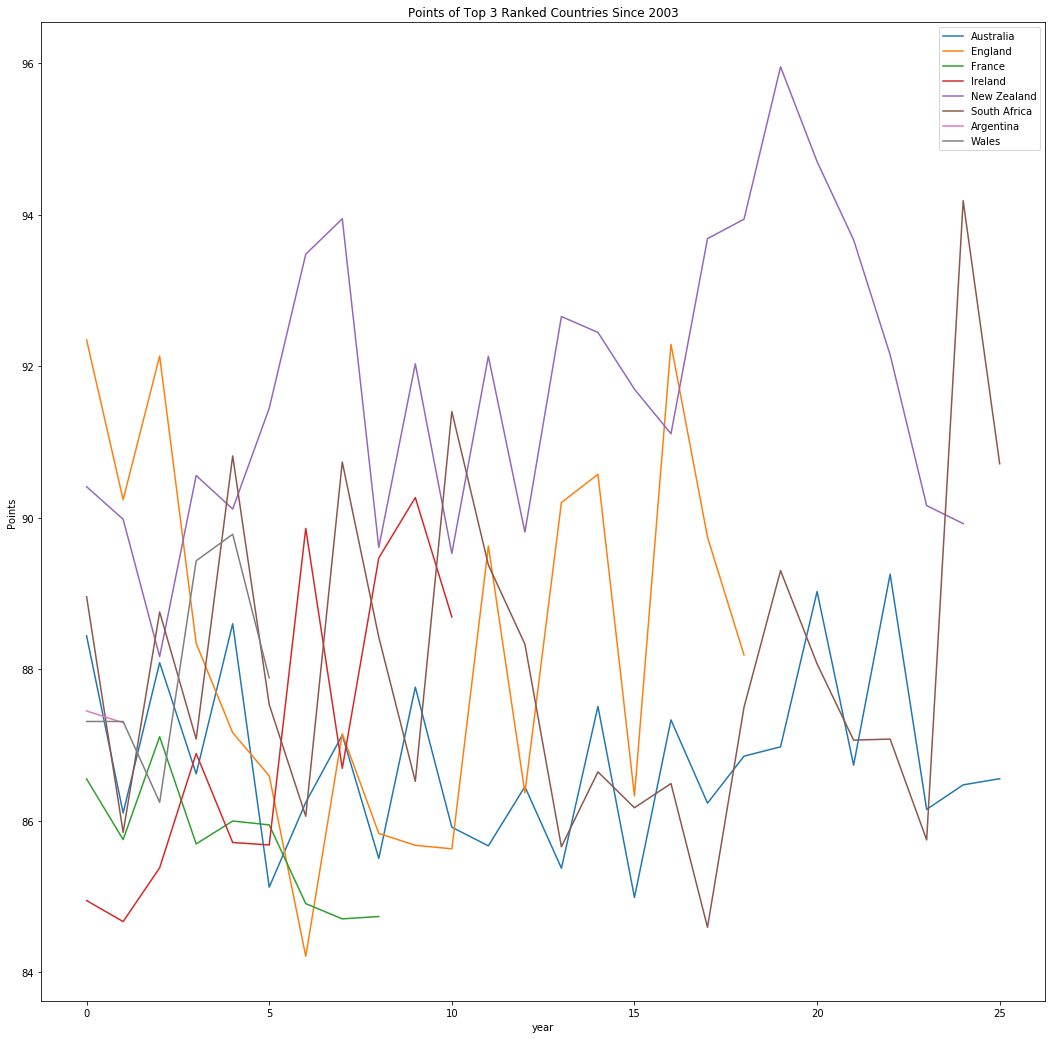

In [12]:
fig = plt.figure(figsize=(18, 18))

for team in data.loc[data.pos < 4].team_name.unique():
    points = data.loc[data.team_name == team].values[:,[3]]
    plt.plot(points, label = team)
    
plt.title("Points of Top 3 Ranked Countries Since 2003")
plt.xlabel("year")
plt.ylabel("Points")
plt.legend()
plt.show()